In [10]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"jordoggon","key":"ca899e946bb5089dabc1e6e17d45770e"}'}

In [11]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumicksarker/openeds-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'openeds-dataset' dataset.
Path to dataset files: /kaggle/input/openeds-dataset


In [13]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# The correct base path is now confirmed to be the path provided by kagglehub
# base_path = "/root/.cache/kagglehub/datasets/soumicksarker/openeds-dataset/versions/2/openEDS/openEDS/train" # Previous incorrect path
base_path = "/kaggle/input/openeds-dataset"
images_dir = os.path.join(base_path, "images")
masks_dir = os.path.join(base_path, "masks")
labels_dir = os.path.join(base_path, "labels")

# Load all files
# Need to adjust paths to match the structure within the kagglehub download
# Based on previous successful cells, the structure is likely openeds-dataset/openEDS/openEDS/train
images_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "images")
masks_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "masks")
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels")


image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

print(f"Attempting to process {len(image_files)} images and {len(mask_files)} masks.")

Attempting to process 27431 images and 27431 masks.


In [14]:
import os

# The correct base path is the one provided by kagglehub
base_path = "/kaggle/input/openeds-dataset"
for folder in os.listdir(base_path):
    print(folder)

openEDS_events
bbox
openEDS


In [15]:
openeds_path = os.path.join(base_path, "openEDS")
print(os.listdir(openeds_path))

['openEDS']


In [16]:
train_path = os.path.join(base_path, "openEDS", "openEDS", "train")
print(os.listdir(train_path))

['labels', 'images', 'masks']


In [17]:
!pip install tqdm opencv-python numpy pillow scikit-learn


In [18]:
# The correct base path is the one provided by kagglehub
base_path = "/kaggle/input/openeds-dataset"
images_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "images")
masks_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "masks")
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels")


print("✅ Found folders:")
print("Images:", len(os.listdir(images_dir)))
print("Masks:", len(os.listdir(masks_dir)))
print("Labels:", len(os.listdir(labels_dir)))

✅ Found folders:
Images: 27431
Masks: 27431
Labels: 27431


# Testing sample subset for training

In [19]:
#Subset loading (for training)
num_samples = 1000  # adjust if you have more GPU memory
image_files = sorted(os.listdir(images_dir))[:num_samples]
mask_files = sorted(os.listdir(masks_dir))[:num_samples]


In [20]:
features = []

for i, mask_name in enumerate(tqdm(mask_files, desc="Extracting features")):
    mask_path = os.path.join(masks_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    # Resize for consistency
    mask = cv2.resize(mask, (128, 128))
    mask = mask / 255.0

    # Calculate pupil features
    pupil_pixels = np.argwhere(mask > 0)
    if pupil_pixels.size == 0:
        features.append([0, 0, 0])
        continue

    y_center, x_center = pupil_pixels.mean(axis=0)
    pupil_area = len(pupil_pixels)
    features.append([x_center, y_center, pupil_area])

features = np.array(features)
print("✅ Features shape:", features.shape)

Extracting features: 100%|██████████| 1000/1000 [00:10<00:00, 99.60it/s]

✅ Features shape: (1000, 3)


In [21]:
# Generate dummy binary labels (you can later replace with true label meanings)
threshold = np.median(features[:, 2])
labels = (features[:, 2] > threshold).astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train lightweight SVM
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.985

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        97
           1       0.98      0.99      0.99       103

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



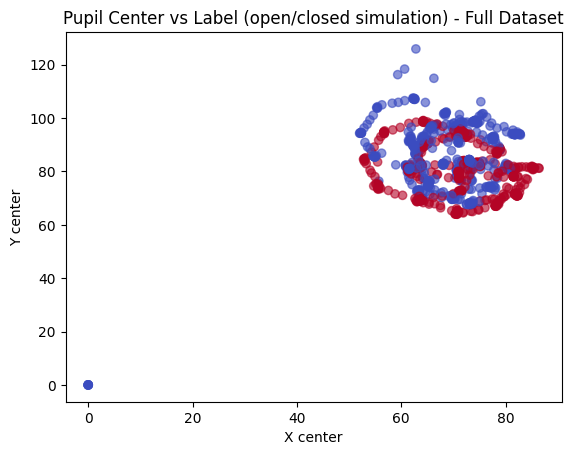

In [22]:
import matplotlib.pyplot as plt

plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("Pupil Center vs Label (open/closed simulation) - Full Dataset")
plt.xlabel("X center")
plt.ylabel("Y center")
plt.show()

## Process more data

In [23]:
base_path = "/kaggle/input/openeds-dataset"
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels")


if os.path.exists(labels_dir):
    print(f"✅ Labels directory found at: {labels_dir}")
    # List a few files in the directory to confirm content
    try:
        label_files_in_dir = sorted(os.listdir(labels_dir))
        print(f"Sample files in labels directory: {label_files_in_dir[:10]}")
        print(f"Total files in labels directory: {len(label_files_in_dir)}")
    except Exception as e:
        print(f"Error listing files in {labels_dir}: {e}")
else:
    print(f"❌ Labels directory not found at: {labels_dir}")

✅ Labels directory found at: /kaggle/input/openeds-dataset/openEDS/openEDS/train/labels
Sample files in labels directory: ['000000.npy', '000001.npy', '000002.npy', '000003.npy', '000004.npy', '000005.npy', '000006.npy', '000007.npy', '000008.npy', '000009.npy']
Total files in labels directory: 27431


##Explore Label Data

In [24]:
# List a few label files
# Correct the path to the labels directory
base_path = "/kaggle/input/openeds-dataset"
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels")

label_files = sorted(os.listdir(labels_dir))
print("Sample label files:", label_files[:10])

# Read a sample label file (assuming they are .npy files based on the listing)
if label_files:
    sample_label_path = os.path.join(labels_dir, label_files[0])
    try:
        # Use np.load to read the .npy file
        sample_label_content = np.load(sample_label_path)
        print(f"\nContent of a sample label file ({label_files[0]}):\n{sample_label_content}")
        print(f"\nShape of the sample label data: {sample_label_content.shape}")
        print(f"\nData type of the sample label data: {sample_label_content.dtype}")

    except Exception as e:
        print(f"Could not read sample label file {label_files[0]} using np.load: {e}")

Sample label files: ['000000.npy', '000001.npy', '000002.npy', '000003.npy', '000004.npy', '000005.npy', '000006.npy', '000007.npy', '000008.npy', '000009.npy']

Content of a sample label file (000000.npy):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Shape of the sample label data: (400, 640)

Data type of the sample label data: uint8


### Incorporate Label Data and Extract More Features

In [25]:
import os
import numpy as np
import cv2
from tqdm import tqdm

features_and_labels = []

# Assuming image_files and mask_files are already loaded with full dataset paths
# Correct the base path to the one provided by kagglehub
base_path = "/kaggle/input/openeds-dataset" # Corrected base path
images_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "images") # Corrected path
masks_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "masks")   # Corrected path
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels") # Corrected path

# Re-load file lists with corrected paths, assuming they were processed sequentially
# In a real scenario, you might want to load these once after correcting paths
# image_files = sorted(os.listdir(images_dir)) # Assuming these are loaded elsewhere or can be loaded here
# mask_files = sorted(os.listdir(masks_dir))   # Assuming these are loaded elsewhere or can be loaded here
# label_files = sorted(os.listdir(labels_dir)) # Assuming these are loaded elsewhere or can be loaded here

# For this modification, let's assume image_files, mask_files, and label_files
# are already loaded from previous cells with the correct paths or load them here for clarity.
# Let's load them here to be sure, using the corrected paths.
try:
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    label_files = sorted(os.listdir(labels_dir))
except FileNotFoundError as e:
    print(f"Error loading file lists: {e}. Ensure the paths are correct and directories exist.")
    image_files = [] # Set to empty to prevent errors in the loop
    mask_files = []
    label_files = []


# Define the target size for resizing (must be consistent)
target_size = (128, 128)

# Ensure all file lists have the same length before processing
if not (len(image_files) == len(mask_files) == len(label_files)):
    print(f"Warning: Number of image, mask, and label files do not match. Images: {len(image_files)}, Masks: {len(mask_files)}, Labels: {len(label_files)}. Processing will be limited to the minimum length.")
    min_len = min(len(image_files), len(mask_files), len(label_files))
    image_files = image_files[:min_len]
    mask_files = mask_files[:min_len]
    label_files = label_files[:min_len]


for i in tqdm(range(len(image_files)), desc="Processing images and extracting features"):
    img_name = image_files[i]
    mask_name = mask_files[i]
    label_name = label_files[i] # Assuming file names match

    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)
    label_path = os.path.join(labels_dir, label_name)

    # Load the label data first, as it's key for region identification
    try:
        label_data = np.load(label_path)
    except Exception as e:
        # print(f"Warning: Could not load label file {label_name}: {e}. Skipping.")
        continue # Skip if label data cannot be loaded


    # Load image and mask (mask might be useful for other things, but labels are primary for regions)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Load mask

    if img is None or mask is None: # Check if image or mask could not be read
        # print(f"Warning: Could not read image or mask for {img_name}. Skipping.")
        continue


    # --- Preprocessing ---
    # Resize image, mask, and label data for consistency
    img_resized = cv2.resize(img, target_size)
    mask_resized = cv2.resize(mask, target_size)
    # Use nearest neighbor for label masks to preserve distinct region values
    label_resized = cv2.resize(label_data, target_size, interpolation=cv2.INTER_NEAREST)


    # --- Feature Extraction based on Label Data ---

    # Features from Pupil (label value 1)
    pupil_pixels = np.argwhere(label_resized == 1)
    if pupil_pixels.size == 0:
        pupil_features = [0, 0, 0] # x_center, y_center, pupil_area
    else:
        # Mean gives the centroid (y, x)
        y_center, x_center = pupil_pixels.mean(axis=0)
        pupil_area = len(pupil_pixels) # Number of pixels with label 1
        pupil_features = [x_center, y_center, pupil_area]

    # Features from Iris (label value 2)
    iris_pixels = np.argwhere(label_resized == 2)
    if iris_pixels.size == 0:
        iris_features = [0, 0, 0] # iris_x_center, iris_y_center, iris_area
    else:
        # Mean gives the centroid (y, x)
        iris_y_center, iris_x_center = iris_pixels.mean(axis=0)
        iris_area = len(iris_pixels) # Number of pixels with label 2
        iris_features = [iris_x_center, iris_y_center, iris_area]

    # Features from Eyelid (label value 3) - Quantify eyelid closure
    eyelid_pixels = np.argwhere(label_resized == 3)
    if eyelid_pixels.size == 0 or pupil_pixels.size == 0:
        # If no eyelid or no pupil detected, closure feature is 0
        eyelid_closure_feature = 0
    else:
        # A more robust approach to eyelid closure:
        # Find the minimum Y-coordinate of the eyelid above the pupil
        # and compare it to the maximum Y-coordinate of the pupil.
        # Lower eyelid_min_y indicates more closure.
        eyelid_y_min = eyelid_pixels[:, 0].min()
        pupil_y_max = pupil_pixels[:, 0].max()

        # Calculate a simple closure measure: difference in y-coordinates
        # Larger positive values indicate more overlap (closure)
        # We can normalize this by the pupil height or image height later if needed
        # For now, let's use the difference
        eyelid_closure_feature = pupil_y_max - eyelid_y_min

        # Ensure the closure feature is not negative (if eyelid is completely above pupil)
        if eyelid_closure_feature < 0:
             eyelid_closure_feature = 0

    # Combine all extracted features
    # Order: pupil_x, pupil_y, pupil_area, iris_x, iris_y, iris_area, eyelid_closure
    all_features = pupil_features + iris_features + [eyelid_closure_feature]


    # --- Store Features ---
    features_and_labels.append(all_features) # We are storing features here, labels will be derived later


# Convert the list to a numpy array
features_array = np.array(features_and_labels)


print("✅ Finished processing. Shape of extracted features:", features_array.shape)

Processing images and extracting features: 100%|██████████| 27431/27431 [11:43<00:00, 39.01it/s]

✅ Finished processing. Shape of extracted features: (27431, 7)


##Visualize Sample Label Mask

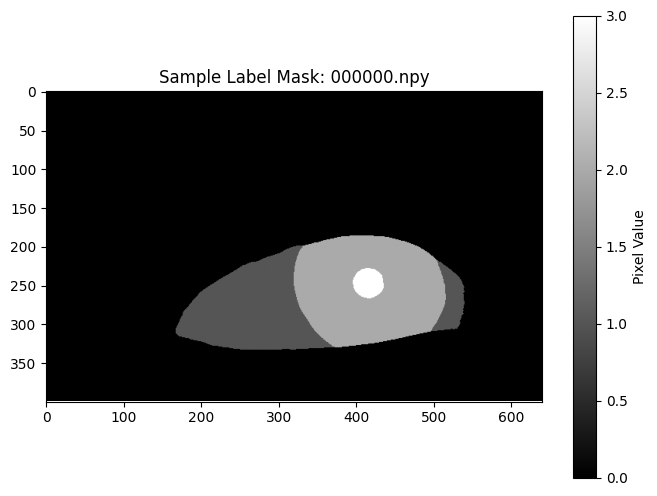

Unique values in sample label mask: [0 1 2 3]


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming label_files and labels_dir are already defined from previous cells
# Correct the path to the labels directory
base_path = "/kaggle/input/openeds-dataset"
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels")

label_files = sorted(os.listdir(labels_dir))

if label_files:
    sample_label_path = os.path.join(labels_dir, label_files[0])
    try:
        sample_label_data = np.load(sample_label_path)

        plt.figure(figsize=(8, 6))
        plt.imshow(sample_label_data, cmap='gray') # Use grayscale colormap for uint8 data
        plt.title(f"Sample Label Mask: {label_files[0]}")
        plt.colorbar(label="Pixel Value")
        plt.show()

        print(f"Unique values in sample label mask: {np.unique(sample_label_data)}")

    except Exception as e:
        print(f"Could not load or visualize sample label file {label_files[0]}: {e}")
else:
    print("No label files found to visualize.")

##Define target variables

In [27]:
import numpy as np

# Define how to derive target variables

# 1. Blinking:
# A simple approach for blinking (binary: 0 for open, 1 for closed)
# can be based on the eyelid closure feature. A high eyelid closure value
# indicates the eyelid is significantly covering the pupil/iris, suggesting a blink.
# We can set a threshold on the eyelid_closure_feature.
# Let's assume the eyelid closure feature is the 4th column (index 3) in our features_array.
# We need to determine an appropriate threshold based on the distribution of this feature.
# For now, let's use a placeholder for the threshold.

# 2. Pupil Size:
# The pupil size can be directly derived from the pupil_area feature (number of pixels
# with label 1). This is already calculated and is the 3rd column (index 2)
# in our features_array. We will use this directly as the target variable for pupil size.

# 3. Gaze Direction:
# Gaze direction can be estimated from the relative position of the pupil centroid
# (label 1) within the iris region (label 2).
# The pupil centroid features are at indices 0 and 1 of features_array.
# The iris centroid features are at indices 4 and 5 of features_array.
# We can calculate the difference between the pupil centroid and the iris centroid
# to get a relative position.
# Relative X position = Pupil X center - Iris X center
# Relative Y position = Pupil Y center - Iris Y center
# These two values can serve as numerical target variables for gaze direction.

# We will create a new array to hold these target variables.
# This array will have columns for blinking (binary), pupil size (numerical),
# and gaze direction (numerical X, numerical Y).

# Placeholder for target variables
target_variables = []

# Assuming the order of features in features_array is:
# [pupil_x_center, pupil_y_center, pupil_area, eyelid_closure, iris_x_center, iris_y_center, iris_area]
# Indices:              0                 1           2               3               4               5           6

# Determine a threshold for blinking (this will need to be refined based on data distribution)
# Ensure features_array is defined and accessible from the previous step where features were extracted.
# If features_array is not defined, this code block needs to be merged with the feature extraction step.
# Assuming features_array is a numpy array from the previous successful execution.

# Check if features_array is defined and not empty
if 'features_array' in locals() and features_array.shape[0] > 0:
    blinking_threshold = np.percentile(features_array[:, 3], 90) # Example: top 10% of closure values are considered blinks

    for features in features_array:
        # Blinking target (binary)
        blinking_status = 1 if features[3] > blinking_threshold else 0 # 1 for closed (blink), 0 for open

        # Pupil Size target (numerical)
        pupil_size = features[2] # Directly use pupil area

        # Gaze Direction targets (numerical X, numerical Y)
        pupil_x, pupil_y = features[0], features[1]
        iris_x, iris_y = features[4], features[5]

        # Calculate relative position of pupil centroid within iris
        # Handle cases where iris or pupil might not be detected (centroid is 0,0)
        # If iris area is 0, relative position is not meaningful, set to 0,0 or a special value
        if features[6] > 0 and features[2] > 0: # Check if both iris and pupil areas are positive
            relative_gaze_x = pupil_x - iris_x
            relative_gaze_y = pupil_y - iris_y
        else:
            relative_gaze_x = 0
            relative_gaze_y = 0 # Or np.nan if you prefer to handle missing values later


        target_variables.append([blinking_status, pupil_size, relative_gaze_x, relative_gaze_y])

    target_variables_array = np.array(target_variables)

    print("✅ Finished defining target variables. Shape:", target_variables_array.shape)
    print("Sample target variables (blinking, pupil_size, gaze_x, gaze_y):")
    print(target_variables_array[:5])
else:
    print("❌ features_array is not defined or is empty. Cannot define target variables.")

✅ Finished defining target variables. Shape: (27431, 4)
Sample target variables (blinking, pupil_size, gaze_x, gaze_y):
[[ 1.00000000e+00  1.12000000e+03 -2.32096545e+01 -1.30120268e+03]
 [ 0.00000000e+00  8.60000000e+02 -2.06404744e+01 -1.22909767e+03]
 [ 1.00000000e+00  1.39300000e+03 -1.32601872e+01 -1.47902297e+03]
 [ 0.00000000e+00  1.05300000e+03 -1.55110373e+01 -1.30682336e+03]
 [ 0.00000000e+00  1.20700000e+03 -3.16232230e+00 -1.25300497e+03]]


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm

features_and_labels = []

# Assuming image_files and mask_files are already loaded with full dataset paths
base_path = "/kaggle/input/openeds-dataset" # Corrected base path
images_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "images") # Corrected path
masks_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "masks")   # Corrected path
labels_dir = os.path.join(base_path, "openEDS", "openEDS", "train", "labels") # Corrected path

# Re-load file lists with corrected paths, assuming they were processed sequentially
# In a real scenario, you might want to load these once after correcting paths
try:
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    label_files = sorted(os.listdir(labels_dir))
except FileNotFoundError as e:
    print(f"Error loading file lists: {e}. Ensure the paths are correct and directories exist.")
    image_files = [] # Set to empty to prevent errors in the loop
    mask_files = []
    label_files = []


# Define the target size for resizing (must be consistent)
target_size = (128, 128)

# Ensure all file lists have the same length before processing
if not (len(image_files) == len(mask_files) == len(label_files)):
    print(f"Warning: Number of image, mask, and label files do not match. Images: {len(image_files)}, Masks: {len(mask_files)}, Labels: {len(label_files)}. Processing will be limited to the minimum length.")
    min_len = min(len(image_files), len(mask_files), len(label_files))
    image_files = image_files[:min_len]
    mask_files = mask_files[:min_len]
    label_files = label_files[:min_len]

min_len = min(len(image_files), len(mask_files), len(label_files))

# Add print statement to check lengths before loop
# print(f"Min length for loop: {min_len}")
print(f"Length of image_files after truncation: {len(image_files)}")
print(f"Length of mask_files after truncation: {len(mask_files)}")
print(f"Length of label_files after truncation: {len(label_files)}")


# Iterate up to the minimum length of the file lists
for i in tqdm(range(min_len), desc="Processing images and extracting features"):
    img_name = image_files[i]
    mask_name = mask_files[i]
    label_name = label_files[i] # Assuming file names match

    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)
    label_path = os.path.join(labels_dir, label_name)

    # Load the label data first, as it's key for region identification
    try:
        label_data = np.load(label_path)
    except Exception as e:
        # print(f"Warning: Could not load label file {label_name}: {e}. Skipping.")
        continue # Skip if label data cannot be loaded


    # Load image and mask (mask might be useful for other things, but labels are primary for regions)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Load mask

    if img is None or mask is None: # Check if image or mask could not be read
        # print(f"Warning: Could not read image or mask for {img_name}. Skipping.")
        continue


    # --- Preprocessing ---
    # Resize image, mask, and label data for consistency
    img_resized = cv2.resize(img, target_size)
    mask_resized = cv2.resize(mask, target_size)
    # Use nearest neighbor for label masks to preserve distinct region values
    label_resized = cv2.resize(label_data, target_size, interpolation=cv2.INTER_NEAREST)


    # --- Feature Extraction based on Label Data ---

    # Features from Pupil (label value 1)
    pupil_pixels = np.argwhere(label_resized == 1)
    if pupil_pixels.size == 0:
        pupil_features = [0, 0, 0] # x_center, y_center, pupil_area
    else:
        # Mean gives the centroid (y, x)
        y_center, x_center = pupil_pixels.mean(axis=0)
        pupil_area = len(pupil_pixels) # Number of pixels with label 1
        pupil_features = [x_center, y_center, pupil_area]

    # Features from Iris (label value 2)
    iris_pixels = np.argwhere(label_resized == 2)
    if iris_pixels.size == 0:
        iris_features = [0, 0, 0] # iris_x_center, iris_y_center, iris_area
    else:
        # Mean gives the centroid (y, x)
        iris_y_center, iris_x_center = iris_pixels.mean(axis=0)
        iris_area = len(iris_pixels) # Number of pixels with label 2
        iris_features = [iris_x_center, iris_y_center, iris_area]

    # Features from Eyelid (label value 3) - Quantify eyelid closure
    eyelid_pixels = np.argwhere(label_resized == 3)
    if eyelid_pixels.size == 0 or pupil_pixels.size == 0:
        # If no eyelid or no pupil detected, closure feature is 0
        eyelid_closure_feature = 0
    else:
        # A more robust approach to eyelid closure:
        # Find the minimum Y-coordinate of the eyelid above the pupil
        # and compare it to the maximum Y-coordinate of the pupil.
        # Lower eyelid_min_y indicates more closure.
        eyelid_y_min = eyelid_pixels[:, 0].min()
        pupil_y_max = pupil_pixels[:, 0].max()

        # Calculate a simple closure measure: difference in y-coordinates
        # Larger positive values indicate more overlap (closure)
        # We can normalize this by the pupil height or image height later if needed
        # For now, let's use the difference
        eyelid_closure_feature = pupil_y_max - eyelid_y_min

        # Ensure the closure feature is not negative (if eyelid is completely above pupil)
        if eyelid_closure_feature < 0:
             eyelid_closure_feature = 0

    # Combine all extracted features
    # Order: pupil_x, pupil_y, pupil_area, iris_x, iris_y, iris_area, eyelid_closure
    all_features = pupil_features + iris_features + [eyelid_closure_feature]


    # --- Store Features ---
    features_and_labels.append(all_features) # We are storing features here, labels will be derived later


# Convert the list to a numpy array
features_array = np.array(features_and_labels)


print("✅ Finished processing. Shape of extracted features:", features_array.shape)

Length of image_files after truncation: 27431
Length of mask_files after truncation: 27431
Length of label_files after truncation: 27431


Processing images and extracting features:   5%|▍         | 1301/27431 [00:24<08:06, 53.66it/s]

##Verify Extracted Features and Target Variables

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming features_array and target_variables_array are available from previous steps

# Convert to pandas DataFrames for easier handling and visualization
# Define column names based on the order of features and target variables
feature_column_names = ['pupil_x_center', 'pupil_y_center', 'pupil_area',
                        'eyelid_closure', 'iris_x_center', 'iris_y_center', 'iris_area']
target_column_names = ['blinking_status', 'pupil_size', 'gaze_x', 'gaze_y']

features_df = pd.DataFrame(features_array, columns=feature_column_names)
targets_df = pd.DataFrame(target_variables_array, columns=target_column_names)

print("✅ Summary statistics for extracted features:")
display(features_df.describe())

print("\n✅ Summary statistics for target variables:")
display(targets_df.describe())

# Visualize distributions of key features and target variables
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(features_df['pupil_area'], kde=True)
plt.title('Distribution of Pupil Area')

plt.subplot(2, 3, 2)
sns.histplot(features_df['eyelid_closure'], kde=True)
plt.title('Distribution of Eyelid Closure Feature')

plt.subplot(2, 3, 3)
sns.histplot(targets_df['blinking_status'])
plt.title('Distribution of Blinking Status')

plt.subplot(2, 3, 4)
sns.histplot(targets_df['pupil_size'], kde=True)
plt.title('Distribution of Pupil Size Target')

plt.subplot(2, 3, 5)
sns.histplot(targets_df['gaze_x'], kde=True)
plt.title('Distribution of Gaze X Target')

plt.subplot(2, 3, 6)
sns.histplot(targets_df['gaze_y'], kde=True)
plt.title('Distribution of Gaze Y Target')

plt.tight_layout()
plt.show()

##

## Prepare Data for Modeling

### Subtask:
Split the data into training and testing sets and scale the features and target variables.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming features_array and target_variables_array are available

# Split data into training and testing sets
# We need to split features and targets together to maintain correspondence
X = features_array
y = target_variables_array

# For simplicity, let's split the data once and use it for all three tasks (blinking, size, gaze)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale numerical target variables (Pupil Size, Gaze X, Gaze Y)
# Blinking status is binary, so it doesn't need scaling
scaler_y_size = StandardScaler()
y_train_size_scaled = scaler_y_size.fit_transform(y_train[:, 1].reshape(-1, 1))
y_test_size_scaled = scaler_y_size.transform(y_test[:, 1].reshape(-1, 1))

scaler_y_gaze_x = StandardScaler()
y_train_gaze_x_scaled = scaler_y_gaze_x.fit_transform(y_train[:, 2].reshape(-1, 1))
y_test_gaze_x_scaled = scaler_y_gaze_x.transform(y_test[:, 2].reshape(-1, 1))

scaler_y_gaze_y = StandardScaler()
y_train_gaze_y_scaled = scaler_y_gaze_y.fit_transform(y_train[:, 3].reshape(-1, 1))
y_test_gaze_y_scaled = scaler_y_gaze_y.transform(y_test[:, 3].reshape(-1, 1))


# Blinking target (already binary)
y_train_blinking = y_train[:, 0]
y_test_blinking = y_test[:, 0]

# Reshape scaled numerical targets back to 1D arrays if needed for some models
y_train_size_scaled = y_train_size_scaled.ravel()
y_test_size_scaled = y_test_size_scaled.ravel()
y_train_gaze_x_scaled = y_train_gaze_x_scaled.ravel()
y_test_gaze_x_scaled = y_test_gaze_x_scaled.ravel()
y_train_gaze_y_scaled = y_train_gaze_y_scaled.ravel()
y_test_gaze_y_scaled = y_test_gaze_y_scaled.ravel()


print("✅ Data splitting and scaling complete.")
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("Shape of y_train_blinking:", y_train_blinking.shape)
print("Shape of y_test_blinking:", y_test_blinking.shape)
print("Shape of y_train_size_scaled:", y_train_size_scaled.shape)
print("Shape of y_test_size_scaled:", y_test_size_scaled.shape)
print("Shape of y_train_gaze_x_scaled:", y_train_gaze_x_scaled.shape)
print("Shape of y_test_gaze_x_scaled:", y_test_gaze_x_scaled.shape)
print("Shape of y_train_gaze_y_scaled:", y_train_gaze_y_scaled.shape)
print("Shape of y_test_gaze_y_scaled:", y_test_gaze_y_scaled.shape)

##Training Models

In [ ]:
from sklearn.linear_model import LogisticRegression # For blinking classification
from sklearn.ensemble import RandomForestRegressor # For pupil size and gaze direction regression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

# --- Train Blinking Classification Model ---
print("Training Blinking Classification Model...")
blinking_model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
blinking_model.fit(X_train_scaled, y_train_blinking)
print("✅ Blinking Model Training Complete.")

# --- Train Pupil Size Regression Model ---
print("\nTraining Pupil Size Regression Model...")
pupil_size_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
pupil_size_model.fit(X_train_scaled, y_train_size_scaled)
print("✅ Pupil Size Model Training Complete.")

# --- Train Gaze Direction Regression Models ---
print("\nTraining Gaze Direction (X) Regression Model...")
gaze_x_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
gaze_x_model.fit(X_train_scaled, y_train_gaze_x_scaled)
print("✅ Gaze Direction (X) Model Training Complete.")

print("\nTraining Gaze Direction (Y) Regression Model...")
gaze_y_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
gaze_y_model.fit(X_train_scaled, y_train_gaze_y_scaled)
print("✅ Gaze Direction (Y) Model Training Complete.")

In [ ]:
import numpy as np

# Assuming features_df and targets_df are available

# Define thresholds based on feature distributions and summary statistics

# 1. Pupil Area Thresholds:
# Let's use the mean and standard deviation as a starting point to define a normal range.
# You might consider values outside of mean +/- 2*std_dev as potentially abnormal.
# Alternatively, based on visualizations, you might define fixed lower and upper bounds
# that visually encompass the majority of typical pupil sizes.
pupil_area_mean = features_df['pupil_area'].mean()
pupil_area_std = features_df['pupil_area'].std()
pupil_area_normal_lower_bound = pupil_area_mean - 2 * pupil_area_std
pupil_area_normal_upper_bound = pupil_area_mean + 2 * pupil_area_std

# Ensure lower bound is not negative
if pupil_area_normal_lower_bound < 0:
    pupil_area_normal_lower_bound = 0

print(f"Pupil Area Normal Range (Mean +/- 2*StdDev): {pupil_area_normal_lower_bound:.2f} to {pupil_area_normal_upper_bound:.2f}")
# Example of alternative fixed thresholds (commented out):
# pupil_area_normal_lower_bound = 300 # Example value - adjust based on data
# pupil_area_normal_upper_bound = 1800 # Example value - adjust based on data
# print(f"Pupil Area Normal Range (Fixed): {pupil_area_normal_lower_bound:.2f} to {pupil_area_normal_upper_bound:.2f}")


# 2. Eyelid Closure Threshold (for Blinking):
# Based on the distribution, a higher value indicates more closure.
# We used a percentile (e.g., 95th percentile) as a threshold for blinking.
# This means the top 5% of closure values are considered blinks.
# You might adjust the percentile (e.g., 90th, 98th) depending on how sensitive
# you want the blinking detection to be.
eyelid_closure_threshold_blink = np.percentile(features_df['eyelid_closure'], 95) # Example: top 5% considered blinks

print(f"Eyelid Closure Threshold for Blinking (95th percentile): {eyelid_closure_threshold_blink:.4f}")
# Example of alternative fixed threshold (commented out):
# eyelid_closure_threshold_blink = 70 # Example value - adjust based on data
# print(f"Eyelid Closure Threshold for Blinking (Fixed): {eyelid_closure_threshold_blink:.4f}")


# 3. Gaze Direction Thresholds (Relative X and Y):
# Assume gaze is normal when the pupil centroid is close to the iris centroid.
# We defined a normal range as mean +/- 2*std_dev for both X and Y.
# Alternatively, you could define a fixed rectangular or circular region
# around the mean relative gaze position that represents normal gaze.
gaze_x_mean = targets_df['gaze_x'].mean()
gaze_y_mean = targets_df['gaze_y'].mean()
gaze_x_std = targets_df['gaze_x'].std()
gaze_y_std = targets_df['gaze_y'].std()

# Let's define a normal range as mean +/- 2*std_dev for both X and Y
gaze_x_normal_lower_bound = gaze_x_mean - 2 * gaze_x_std
gaze_x_normal_upper_bound = gaze_x_mean + 2 * gaze_x_std
gaze_y_normal_lower_bound = gaze_y_mean - 2 * gaze_y_std
gaze_y_normal_upper_bound = gaze_y_mean + 2 * gaze_y_std


print(f"Gaze X Normal Range (Mean +/- 2*StdDev): {gaze_x_normal_lower_bound:.2f} to {gaze_x_normal_upper_bound:.2f}")
print(f"Gaze Y Normal Range (Mean +/- 2*StdDev): {gaze_y_normal_lower_bound:.2f} to {gaze_y_normal_upper_bound:.2f}")

# Example of alternative fixed rectangular thresholds (commented out):
# gaze_x_normal_lower_bound = -30 # Example value - adjust based on data
# gaze_x_normal_upper_bound = 20 # Example value - adjust based on data
# gaze_y_normal_lower_bound = -1400 # Example value - adjust based on data
# gaze_y_normal_upper_bound = -700 # Example value - adjust based on data
# print(f"Gaze X Normal Range (Fixed): {gaze_x_normal_lower_bound:.2f} to {gaze_x_normal_upper_bound:.2f}")
# print(f"Gaze Y Normal Range (Fixed): {gaze_y_normal_lower_bound:.2f} to {gaze_y_normal_upper_bound:.2f}")


print("\n✅ Preliminary thresholds defined. Review and adjust these based on your specific criteria for 'normal' eye movements.")

# You can now use these defined thresholds to classify new data points as 'normal' or 'abnormal'
# For example, to check if a new data point 'new_features' is within the normal pupil area range:
# is_pupil_area_normal = (new_features[2] >= pupil_area_normal_lower_bound) and (new_features[2] <= pupil_area_normal_upper_bound)

# To check for blinking:
# is_blinking = new_features[3] > eyelid_closure_threshold_blink

# To check if gaze is normal:
# is_gaze_x_normal = (new_features[6] >= gaze_x_normal_lower_bound) and (new_features[6] <= gaze_x_normal_upper_bound)
# is_gaze_y_normal = (new_features[7] >= gaze_y_normal_lower_bound) and (new_features[7] <= gaze_y_normal_upper_bound)

# Note: The indices for new_features would depend on the order of features when you process new data.

## Define "Normal" Thresholds

### Subtask:
Define numerical thresholds for key features to identify potentially "normal" vs. "abnormal" eye movements.

In [ ]:
import numpy as np

# Assuming X_test_scaled, blinking_model, pupil_size_model, gaze_x_model, gaze_y_model,
# scaler_y_size, scaler_y_gaze_x, scaler_y_gaze_y,
# pupil_area_normal_lower_bound, pupil_area_normal_upper_bound,
# eyelid_closure_threshold_blink,
# gaze_x_normal_lower_bound, gaze_x_normal_upper_bound,
# gaze_y_normal_lower_bound, gaze_y_normal_upper_bound
# are available from preceding cells.

print("✅ Demonstrating pipeline application on test data samples:")

# Select a few samples from the test set to demonstrate
num_demo_samples = 10 # You can adjust this number
if X_test_scaled.shape[0] < num_demo_samples:
    num_demo_samples = X_test_scaled.shape[0]

# Get the features for the demo samples
demo_features_scaled = X_test_scaled[:num_demo_samples]
# Also get the original features for comparison if needed (optional)
# demo_features_original = X_test[:num_demo_samples] # Need X_test if not available

# Make predictions using the trained models
predicted_blinking_status = blinking_model.predict(demo_features_scaled)
predicted_pupil_size_scaled = pupil_size_model.predict(demo_features_scaled)
predicted_gaze_x_scaled = gaze_x_model.predict(demo_features_scaled)
predicted_gaze_y_scaled = gaze_y_model.predict(demo_features_scaled)

# Inverse transform scaled regression predictions to original scale
predicted_pupil_size = scaler_y_size.inverse_transform(predicted_pupil_size_scaled.reshape(-1, 1)).ravel()
predicted_gaze_x = scaler_y_gaze_x.inverse_transform(predicted_gaze_x_scaled.reshape(-1, 1)).ravel()
predicted_gaze_y = scaler_y_gaze_y.inverse_transform(predicted_gaze_y_scaled.reshape(-1, 1)).ravel()


# Apply defined "normal" thresholds to classify predictions
print("\n--- Classification Results for Demo Samples ---")
for i in range(num_demo_samples):
    sample_blinking = predicted_blinking_status[i]
    sample_pupil_size = predicted_pupil_size[i]
    sample_gaze_x = predicted_gaze_x[i]
    sample_gaze_y = predicted_gaze_y[i]

    # Classify Blinking
    blinking_classification = "Blink (Abnormal based on threshold)" if sample_blinking == 1 else "No Blink (Normal based on threshold)"

    # Classify Pupil Size
    if sample_pupil_size >= pupil_area_normal_lower_bound and sample_pupil_size <= pupil_area_normal_upper_bound:
        pupil_size_classification = "Normal Pupil Size"
    else:
        pupil_size_classification = "Abnormal Pupil Size (outside normal range)"

    # Classify Gaze Direction
    if sample_gaze_x >= gaze_x_normal_lower_bound and sample_gaze_x <= gaze_x_normal_upper_bound and \
       sample_gaze_y >= gaze_y_normal_lower_bound and sample_gaze_y <= gaze_y_normal_upper_bound:
        gaze_classification = "Normal Gaze Direction"
    else:
        gaze_classification = "Abnormal Gaze Direction (outside normal range)"

    print(f"\nSample {i+1}:")
    print(f"  Predicted Blinking: {sample_blinking} ({blinking_classification})")
    print(f"  Predicted Pupil Size: {sample_pupil_size:.2f} ({pupil_size_classification})")
    print(f"  Predicted Gaze (X, Y): ({sample_gaze_x:.2f}, {sample_gaze_y:.2f}) ({gaze_classification})")

    # Overall assessment for the sample (example logic - refine as needed)
    if "Abnormal" in blinking_classification or "Abnormal" in pupil_size_classification or "Abnormal" in gaze_classification:
        overall_assessment = "POTENTIALLY ABNORMAL EYE MOVEMENT"
    else:
        overall_assessment = "Normal Eye Movement"

    print(f"  Overall Assessment: {overall_assessment}")

In [ ]:
import numpy as np

# Assuming X_test_scaled, blinking_model, pupil_size_model, gaze_x_model, gaze_y_model,
# scaler_y_size, scaler_y_gaze_x, scaler_y_gaze_y,
# pupil_area_normal_lower_bound, pupil_area_normal_upper_bound,
# eyelid_closure_threshold_blink,
# gaze_x_normal_lower_bound, gaze_x_normal_upper_bound,
# gaze_y_normal_lower_bound, gaze_y_normal_upper_bound
# are available from preceding cells.

print("✅ Analyzing the overall rate of abnormal detections in the test set:")

# Make predictions for the entire test set
predicted_blinking_status_test = blinking_model.predict(X_test_scaled)
predicted_pupil_size_scaled_test = pupil_size_model.predict(X_test_scaled)
predicted_gaze_x_scaled_test = gaze_x_model.predict(X_test_scaled)
predicted_gaze_y_scaled_test = gaze_y_model.predict(X_test_scaled)

# Inverse transform scaled regression predictions to original scale
predicted_pupil_size_test = scaler_y_size.inverse_transform(predicted_pupil_size_scaled_test.reshape(-1, 1)).ravel()
predicted_gaze_x_test = scaler_y_gaze_x.inverse_transform(predicted_gaze_x_scaled_test.reshape(-1, 1)).ravel()
predicted_gaze_y_test = scaler_y_gaze_y.inverse_transform(predicted_gaze_y_scaled_test.reshape(-1, 1)).ravel()

# Initialize counter for abnormal detections
abnormal_count = 0
total_samples = X_test_scaled.shape[0]

# Apply defined "normal" thresholds to classify each sample in the test set
for i in range(total_samples):
    sample_blinking = predicted_blinking_status_test[i]
    sample_pupil_size = predicted_pupil_size_test[i]
    sample_gaze_x = predicted_gaze_x_test[i]
    sample_gaze_y = predicted_gaze_y_test[i]

    # Check for abnormality in each feature based on thresholds
    is_blinking_abnormal = sample_blinking == 1 # Blinking predicted as 1 is considered abnormal based on the threshold approach
    is_pupil_size_abnormal = not (sample_pupil_size >= pupil_area_normal_lower_bound and sample_pupil_size <= pupil_area_normal_upper_bound)
    is_gaze_x_abnormal = not (sample_gaze_x >= gaze_x_normal_lower_bound and sample_gaze_x <= gaze_x_normal_upper_bound)
    is_gaze_y_abnormal = not (sample_gaze_y >= gaze_y_normal_lower_bound and sample_gaze_y <= gaze_y_normal_upper_bound)

    # Determine overall abnormal status (if any feature is abnormal)
    if is_blinking_abnormal or is_pupil_size_abnormal or is_gaze_x_abnormal or is_gaze_y_abnormal:
        abnormal_count += 1

# Calculate the rate of abnormal detections
abnormal_rate = (abnormal_count / total_samples) * 100 if total_samples > 0 else 0

print(f"\n--- Overall Abnormal Detection Rate in Test Set ---")
print(f"Total samples in test set: {total_samples}")
print(f"Number of samples classified as potentially abnormal: {abnormal_count}")
print(f"Overall rate of potentially abnormal detections: {abnormal_rate:.2f}%")

print("\nNote: This rate is based on the defined 'normal' thresholds and the models' predictions.")

## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression # For blinking classification
from sklearn.ensemble import RandomForestRegressor # For pupil size and gaze direction regression
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.model_selection import train_test_split # Import train_test_split
import numpy as np # Import numpy
from sklearn.utils.validation import check_is_fitted # Import check_is_fitted
from sklearn.exceptions import NotFittedError # Import NotFittedError


# Check if data is prepared and models/scalers are trained
# Using check_is_fitted for models for more specific checks
try:
    X_test_scaled # Check if scaled test features are available
    y_test_blinking # Check if blinking test labels are available
    y_test # Check if original test targets are available

    # Check if each model is fitted
    check_is_fitted(blinking_model)
    check_is_fitted(pupil_size_model)
    check_is_fitted(gaze_x_model)
    check_is_fitted(gaze_y_model)

    # Check if scalers are fitted (for inverse transform)
    check_is_fitted(scaler_y_size)
    check_is_fitted(scaler_y_gaze_x)
    check_is_fitted(scaler_y_gaze_y)

except NotFittedError as e:
     print(f"❌ Error: A model or scaler is not fitted. Please ensure the model training cells (like fe3e06db) have been run successfully. Details: {e}")
except NameError as e:
     print(f"❌ Error: Required variables (data or models/scalers) are not found. Please ensure the preceding data preparation and model training cells have been run successfully. Details: {e}")
except Exception as e:
     print(f"❌ An unexpected error occurred during the initial check: {e}")


# If checks pass, proceed with evaluation
if 'X_test_scaled' in locals() and 'y_test_blinking' in locals() and 'y_test' in locals():
    try:
        # --- Evaluate Blinking Classification Model ---
        print("\nEvaluating Blinking Classification Model...")
        y_pred_blinking = blinking_model.predict(X_test_scaled)
        print("✅ Blinking Model Evaluation:")
        print("Accuracy:", accuracy_score(y_test_blinking, y_pred_blinking))
        print("Classification Report:\n", classification_report(y_test_blinking, y_pred_blinking))

        # --- Evaluate Pupil Size Regression Model ---
        print("\nEvaluating Pupil Size Regression Model...")
        y_pred_size_scaled = pupil_size_model.predict(X_test_scaled)

        # Inverse transform the scaled predictions to get predictions in original scale
        # Ensure y_test is available and has the correct structure
        y_pred_size = scaler_y_size.inverse_transform(y_pred_size_scaled.reshape(-1, 1)).ravel()
        # y_test_size = y_test[:, 1] # y_test is already available from the split

        print("✅ Pupil Size Model Evaluation:")
        print("Mean Squared Error:", mean_squared_error(y_test[:, 1], y_pred_size))
        print("R2 Score:", r2_score(y_test[:, 1], y_pred_size))

        # --- Evaluate Gaze Direction Regression Models ---
        print("\nEvaluating Gaze Direction (X) Regression Model...")
        y_pred_gaze_x_scaled = gaze_x_model.predict(X_test_scaled)
        y_pred_gaze_x = scaler_y_gaze_x.inverse_transform(y_pred_gaze_x_scaled.reshape(-1, 1)).ravel()
        # y_test_gaze_x = y_test[:, 2] # y_test is already available from the split

        print("✅ Gaze Direction (X) Model Evaluation:")
        print("Mean Squared Error:", mean_squared_error(y_test[:, 2], y_pred_gaze_x))
        print("R2 Score:", r2_score(y_test[:, 2], y_pred_gaze_x))

        print("\nEvaluating Gaze Direction (Y) Regression Model...")
        y_pred_gaze_y_scaled = gaze_y_model.predict(X_test_scaled)
        y_pred_gaze_y = scaler_y_gaze_y.inverse_transform(y_pred_gaze_y_scaled.reshape(-1, 1)).ravel()
        # y_test_gaze_y = y_test[:, 3] # y_test is already available from the split

        print("✅ Gaze Direction (Y) Model Evaluation:")
        print("Mean Squared Error:", mean_squared_error(y_test[:, 3], y_pred_gaze_y))
        print("R2 Score:", r2_score(y_test[:, 3], y_pred_gaze_y)) # Corrected typo here

    except NotFittedError as e:
         print(f"❌ Error during evaluation: A model or scaler was not fitted correctly before attempting prediction/transform. Details: {e}")
    except NameError as e:
         print(f"❌ Error during evaluation: Required variables (models or scalers) were not found. Details: {e}")
    except Exception as e:
         print(f"❌ An unexpected error occurred during evaluation: {e}")
else:
    print("\nEvaluation skipped due to missing data or models/scalers.")